# 10. Transformer로 번역기 만들기

**트랜스포머를 이용해 번역기를 만들어 본다. 먼저 내부 모듈을 하나하나 구현한 후, 조립하여 완성한다. 완성된 번역기를 테스트해 본다.**

## 10-1. 들어가며

```bash
$ mkdir -p ~/aiffel/transformer
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


## 10-2. 내부 모듈 구현하기

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.6.0


In [3]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

print("슝=3")

슝=3


In [5]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


여기까지 내부에 포함될 모듈들을 모두 완성하셨습니다, 대단해요! 이 모든 모듈들을 가지고 트랜스포머를 완성할 수 있는데, 정확하게는 트랜스포머의 Encoder 한 층과 Decoder 한 층을 각각 완성할 수 있습니다!

그럼 이만큼의 코드를 5번 더 짜야 여섯 층짜리 논문 속 트랜스포머가 완성되나요..?

이런 걱정을 하셨다면 안심하세요, 우리는 조금 더 멋지고 효율적인 방법으로 트랜스포머를 완성할 거니까요!

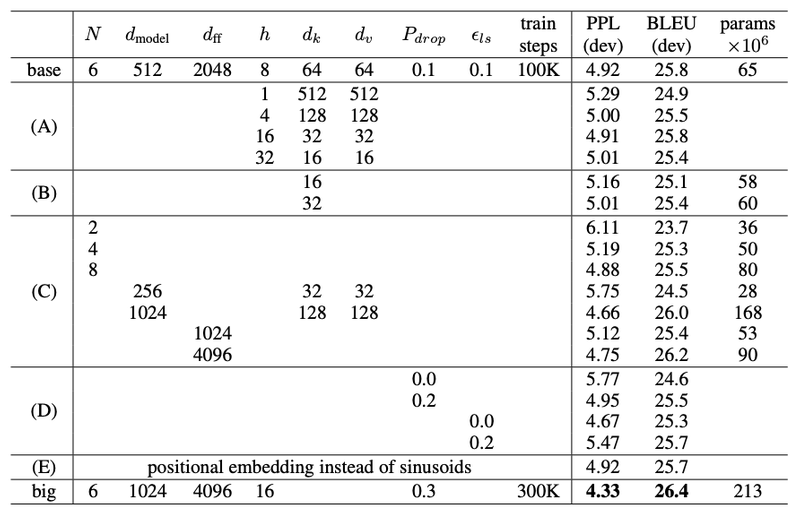

강의 노드가 아닌데 갑자기 표? 뜬금없지만 <Attention Is All You Need> 논문에 포함된 이 표는 트랜스포머가 얼마나 많은 실험을 통해서 탄생한 모델인지 보여줍니다. 이런 실험이 가능하게 하려면 모델이 동적으로 완성될 수 있게끔 해야 해요. 즉, 레이어 수를 원하는 만큼 쌓아 실험을 자유자재로 할 수 있게 모델을 완성하자는 거죠!

방법은 단순합니다, 마치 텐서플로우의 Dense 레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게 tf.keras.layers.Layer 클래스를 상속받아 레이어 클래스로 정의해 주면 돼요. 여러분은 이미 Layer 클래스를 정의해 본 적이 있는데, 바로 직전의 MultiHeadAttention 이 그렇게 정의된 레이어랍니다! 이 방법을 사용하면 아래와 같은 용법으로 트랜스포머 레이어를 사용할 수 있죠.

In [ ]:

# N = 10

# # 10개의 Linear Layer를 한 방에!
# linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]

# # 10개의 Encoder Layer도 한 방에!
# enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]

## 10-3. 모듈 조립하기

In [7]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


In [8]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [10]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [11]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


## 10-4. 모델 밖의 조력자들

In [12]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


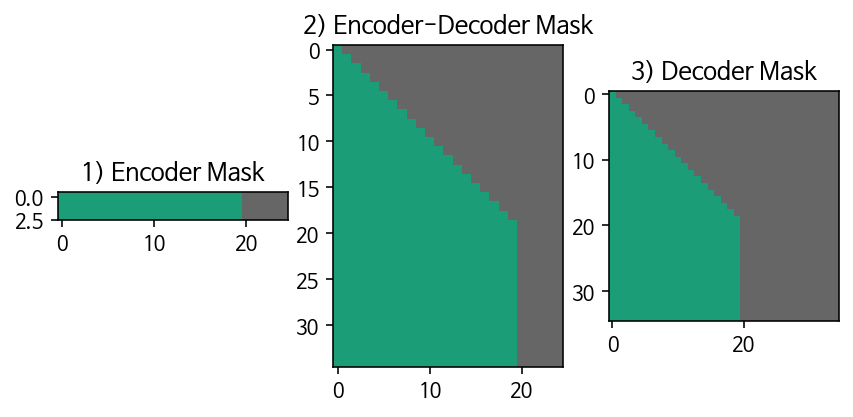

In [13]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [14]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


## 10-5. 프로젝트: 더 멋진 번역기 만들기

In [15]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


```bash
$ ln -s ~/data ~/aiffel/transformer/data
```

In [16]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r", encoding='utf-8') as f:
        kor = f.read().splitlines()
    with open(eng_path, "r", encoding='utf-8') as f:
        eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # 정제 및 중복 제거
    cleaned_corpus = set()
    for k, e in zip(kor, eng):
        k = re.sub(r"([?.!,])", r" \1 ", k)
        k = re.sub(r'[" "]+', " ", k)
        k = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", k)
        k = k.strip()

        e = e.lower().strip()
        e = re.sub(r"([?.!,])", r" \1 ", e)
        e = re.sub(r'[" "]+', " ", e)
        e = re.sub(r"[^a-zA-Z?.!,]+", " ", e)
        e = e.strip()

        cleaned_corpus.add((k, e))

    return list(cleaned_corpus)

cleaned_corpus = clean_corpus(kor_path, eng_path)

print(f"Cleaned Corpus Size: {len(cleaned_corpus)}")

Cleaned Corpus Size: 78802


In [18]:
import re

def preprocess_sentence(sentence):
    # 모든 입력을 소문자로 변환합니다.
    sentence = sentence.lower()
    # 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence)
    # 문장부호 양옆에 공백을 추가합니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 문장 앞뒤의 불필요한 공백을 제거합니다.
    sentence = sentence.strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    return sentence

# 테스트
print(preprocess_sentence("안녕하세요? Hello, World!   이것은 테스트 문장입니다."))

안녕하세요 ? hello , world ! 이것은 테스트 문장입니다 .


In [21]:
import sentencepiece as spm

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                       vocab_size=20000,
                       lang="ko",
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    # 임시 파일에 말뭉치를 저장
    temp_file = f"{lang}_corpus.txt"
    with open(temp_file, 'w', encoding='utf-8') as f:
        for sentence in corpus:
            f.write(f"{sentence}\n")

    # SentencePiece 모델 학습
    spm.SentencePieceTrainer.Train(
        f"--input={temp_file} --model_prefix={lang}_tokenizer --vocab_size={vocab_size} "
        f"--pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id} "
        f"--character_coverage=0.9995 --model_type=bpe"
    )

    # 학습된 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f"{lang}_tokenizer.model")

    return tokenizer

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

# 'tuple' object has no attribute 'split' 이기에 수정하였습니다.
for k, e in cleaned_corpus:
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

# 테스트
print("Korean tokenizer example: ", ko_tokenizer.EncodeAsPieces("안녕하세요"))
print("English tokenizer example: ", en_tokenizer.EncodeAsPieces("hello world"))


Korean tokenizer example:  ['▁안', '녕', '하', '세요']
English tokenizer example:  ['<s>', '▁hello', '▁world', '</s>']


In [22]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    kor_tokens = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    eng_tokens = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(kor_tokens) <= 50 and len(eng_tokens) <= 50:
        src_corpus.append(kor_tokens)
        tgt_corpus.append(eng_tokens)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

print(f"Encoded training data shape: {enc_train.shape}, {dec_train.shape}")

  0%|          | 0/78802 [00:00<?, ?it/s]

Encoded training data shape: (75614, 50), (75614, 50)


### Transformer 모델 설계

In [35]:
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import random

# Positional Encoding
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

- MultiHeadAttention, PoswiseFeedForwardNet, EncoderLayer, DecoderLayer, Encoder, Decoder 클래스는 위의 코드를 사용합니다.
- generate_padding_mask, generate_causality_mask, generate_masks 함수는 위의 코드를 사용합니다.
- LearningRateScheduler 클래스는 위의 코드를 사용합니다.

In [36]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self.__init__)
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out
        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

# 패딩 및 원인 마스크 생성
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [37]:
# Transformer 모델 초기화
d_model = 512 # 을 쓰지 않고 바로 LearningRateScheduler로 넣었다
n_layers = 2
n_heads = 8
d_ff = 2048
src_vocab_size = 20000
tgt_vocab_size = 20000
pos_len = 50
dropout_rate = 0.1

In [38]:
# transformer = Transformer(n_layers, d_model, n_heads, d_ff,
#                           src_vocab_size, tgt_vocab_size, pos_len,
#                           dropout=dropout_rate, shared=True)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [39]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [40]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [28]:
# # Train Step 함수 정의 ( 수정 이전 )

# @tf.function
# def train_step(inp, tar, transformer, optimizer):
#     tar_inp = tar[:, :-1]
#     tar_real = tar[:, 1:]

#     enc_mask, combined_mask, dec_mask = generate_masks(inp, tar_inp)

#     with tf.GradientTape() as tape:
#         predictions, enc_attns, dec_attns, dec_enc_attns = transformer(inp, tar_inp, True, enc_mask, combined_mask, dec_mask)
#         loss = loss_function(tar_real, predictions)

#     gradients = tape.gradient(loss, transformer.trainable_variables)    
#     optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

#     return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# Attention 시각화 함수



def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [42]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [43]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

```python
# 학습 과정 코드

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
```

>## **루브릭**
>
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|
>|2|Transformer 번역기 모델이 정상적으로 구동된다.|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|
>|3|테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|

### 학습 과정

In [44]:
# 학습 루프
from tqdm.notebook import tqdm

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

  0%|          | 0/1182 [00:00<?, ?it/s]

TypeError: in user code:

    /tmp/ipykernel_56/1322929738.py:11 train_step  *
        predictions, enc_attns, dec_attns, dec_enc_attns = transformer(inp, tar_inp, True, enc_mask, combined_mask, dec_mask)

    TypeError: tf__call() takes 6 positional arguments but 7 were given


- 오류 feedback
- train_step 함수가 Transformer 모델의 call 메서드를 호출할 때 call 메서드에 전달되는 인수의 수가 맞지 않습니다. 
- train_step 함수에서 transformer의 call 메서드에 전달되는 인수의 수를 확인하고, 전체 코드를 올바르게 수정하려 시도하였습니다.

In [45]:
# Train Step 함수
@tf.function
def train_step(inp, tar, transformer, optimizer):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_mask, combined_mask, dec_mask = generate_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = transformer(inp, tar_inp, enc_mask, combined_mask, dec_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 학습 루프
BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president elect is a third of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the man has been a little .
Input: 커피는 필요 없다.
Predicted translation: it s not be a lot of the way .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths were killed .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in the presidential vote .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city s main city of the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is not only .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is one of the most popular vote .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban city is a bit .
Input: 커피는 필요 없다.
Predicted translation: there is nothing you don t just don t just don t just ask you don t need you don t need you need you .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were wounded .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he s the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s cities is a city .
Input: 커피는 필요 없다.
Predicted translation: coffee is nothing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven crew members were killed .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is on his first term .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban air force is in the city for a minute .
Input: 커피는 필요 없다.
Predicted translation: the coffee isn t quite a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven crew members of the local media reported that the deaths of seven people .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is going to .
Input: 시민들은 도시 속에 산다.
Predicted translation: they hope the urban biscayevity to eight people .
Input: 커피는 필요 없다.
Predicted translation: the truth is .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he was the first class of .
Input: 시민들은 도시 속에 산다.
Predicted translation: city you re cities in big cities .
Input: 커피는 필요 없다.
Predicted translation: we don t need anything . . . . . . no . position
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the seven days .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is on the first leg of his campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: to urban polaroid is one of the city s city .
Input: 커피는 필요 없다.
Predicted translation: coffee cannot be a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the remainder are .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s streets are san diego .
Input: 커피는 필요 없다.
Predicted translation: the coffee is no one . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven others died in the morning .


  0%|          | 0/1182 [00:00<?, ?it/s]

### 회고
-
-